# FNC Model aplicado ao Oscilador Harmônico

Esse notebook contém o modelo de rede neural FNC (Fully Convolutional Network) aplicado ao lançamento de um projétil
## Overview

Considere que o vetor posição é de tal forma que
$$
    \vec{r}(t) = (r_{x}(t), r_{y}(t))
$$

Onde a velocidade é dada por:

$$
    \vec{v}(t) = \left(\dfrac{dr_{x}}{dt}, \dfrac{dr_{y}}{dt}\right)
$$

A equação diferencial que governa o problema, é dada por:
$$
-\mu \left|\dfrac{d\vec{r}}{dt}\right|\dfrac{d\vec{r}}{dt} -\vec{g} - \dfrac{d^{2}\vec{r}}{dt^{2}} = 0
$$

Onde $\mu$ é um coeficiente de arraste normalizado pela massa.

# Import modules

In [56]:
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Define util functions

In [57]:
def saveGif(outfile, files, fps=5, loop=0):
    "Helper function for saving GIFs"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)

def plotResult(x, y, x_data, y_data, labelY, labelY_data, title, fileName, yLimInf = -1, yLimSup = 1):
    plt.style.use('default')
    fig1 = plt.figure(figsize=(8,6))
    axes = fig1.add_axes([0.1,0.1,0.8,0.8])

    axes.plot(x, y, label=labelY)
    axes.scatter(x_data, y_data, color="tab:orange", label=labelY_data)
    
    axes.set_xlabel('x coordinate')
    axes.set_ylabel('y coordinate')

    axes.set_title(title)
    # plt.ylim([yLimInf, yLimSup])
    plt.legend()
    plt.grid(linestyle='-', linewidth=0.5)
    plt.savefig(fileName, dpi=400)


def plotPrettyResult(x,y,x_data,y_data,yh,xp=None):
    "Pretty plot training results"
    plt.figure(figsize=(8,4))
    plt.plot(x,y, color="grey", linewidth=2, alpha=0.8, label="Analytical solution")
    plt.plot(x,yh, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=30, color="tab:green", alpha=0.4, 
                    label='Physical training data')
    l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(-0.05, 1.05)
    plt.ylim(-1.1, 1.1)
    plt.text(1.065,0.7,"Training step: %i"%(i+1),fontsize="xx-large",color="k")
    plt.axis("off")

# Define Runge-Kutta methods

In [58]:
def f(t, v, g, m, k):
    kmv = np.linalg.norm(v)*(k/m)
    return (g - kmv*v)

def RK4(tn, rn, vn, h, g, m, k):

    k1v = f(tn, vn, g, m, k)
    k2v = f(tn + h/2, vn + k1v*h/2, g, m, k)
    k3v = f(tn + h/2, vn + k2v*h/2, g, m, k)
    k4v = f(tn + h, vn + k3v*h, g, m, k)
    vn1 = vn + (k1v + 2*k2v + 2*k3v + k4v)*(h/6)

    k1r = vn
    k2r = vn + k1v*h/2
    k3r = vn + k2v*h/2
    k4r = vn + k3v*h
    rn1 = rn + (k1r + 2*k2r + 2*k3r + k4r)*(h/6)
    # xn1 = xn + vn*h + (k1v+k2v+k3v)*h**2/6

    return vn1, rn1

In [59]:
theta = np.radians(30)
v0 = np.array([8*np.cos(theta), 8*np.sin(theta)])
r0 = np.array([0, 0])
t0 = 0
r = []
v = [] 
t = []
r.append(r0)
v.append(v0)
t.append(t0)

m = 1
k = 0.01
g = np.array([0, -9.81])
h = 0.01

tn = t0
vn = v0
rn = r0
maxt = 1

while (tn < maxt):
   vn, rn = RK4(tn, rn, vn, h, g, m, k)
   tn = tn + h
   t.append(tn)
   r.append(rn)
   v.append(vn)

print(r)

[array([0, 0]), array([0.06925439, 0.03949367]), array([0.13845378, 0.07797537]), array([0.20759858, 0.11544609]), array([0.27668921, 0.15190684]), array([0.34572606, 0.18735859]), array([0.41470953, 0.22180231]), array([0.48364   , 0.25523894]), array([0.55251785, 0.28766942]), array([0.62134344, 0.31909467]), array([0.69011714, 0.34951559]), array([0.75883929, 0.37893308]), array([0.82751024, 0.40734801]), array([0.89613031, 0.43476126]), array([0.96469985, 0.46117367]), array([1.03321915, 0.4865861 ]), array([1.10168853, 0.51099937]), array([1.17010829, 0.5344143 ]), array([1.23847871, 0.55683169]), array([1.30680008, 0.57825236]), array([1.37507266, 0.59867708]), array([1.44329672, 0.61810663]), array([1.5114725 , 0.63654178]), array([1.57960026, 0.65398329]), array([1.64768022, 0.6704319 ]), array([1.7157126 , 0.68588837]), array([1.78369763, 0.70035341]), array([1.85163551, 0.71382776]), array([1.91952642, 0.72631214]), array([1.98737056, 0.73780726]), array([2.05516811, 0.748313

In [60]:
def parametricCoordinates(r):

    x = []
    y = []

    for position in r:
        x.append(position[0])
        y.append(position[1])

    return x, y

## Plot solutions

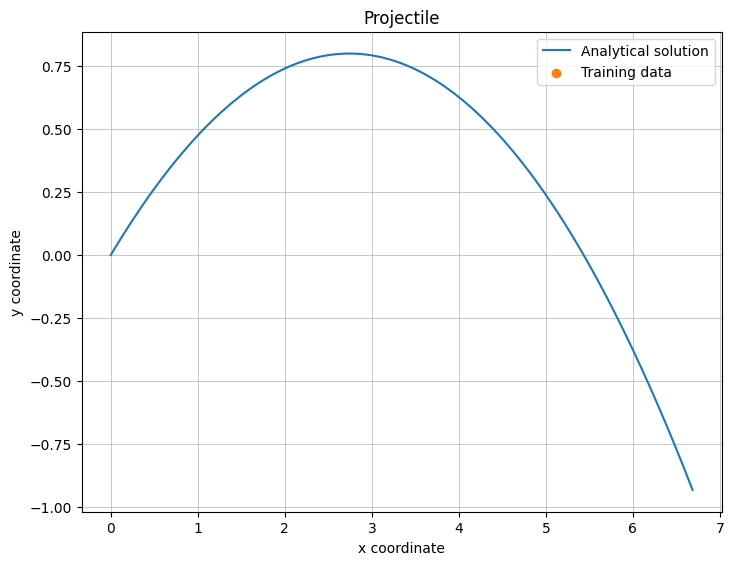

In [61]:
x, y = parametricCoordinates(r)

plotResult(x, y, [], [], 'Analytical solution', 'Training data', 'Projectile', 'plots/projectile1.png')